In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
# Add the path to the utils directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from import_funcs import * #list_files_with_extension, extract_data_inline
import matplotlib.pyplot as plt

In [6]:
path = './data'
txt_files = list_files_with_extension(path, '.txt')

# Add a 'time_index' column before concatenating all_X
all_X = []

for file in txt_files:
    # Extract condition (text after last underscore, before .txt)
    condition = Path(file).stem.split('_')[-1]
    # Extract data
    idx_start, idx_stop, delta_time, T, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['condition'] = condition
    all_X.append(X_local)

all_X = pd.concat(all_X, ignore_index=True)

In [7]:
all_X.condition.unique()

array(['25C', 'v2', '50C'], dtype=object)

In [11]:
all_X.columns

Index(['V_rad_short', 'V_rad_tot', 'V_housing', 'V_diode', 'V_spike',
       'cooling_flag_1', 'cooling_flag_2', 'time_index', 'condition'],
      dtype='object')

In [10]:
all_X = all_X[all_X['condition'].isin(['v2'])]
all_X.condition.unique()

array(['v2'], dtype=object)

In [14]:
# Find indices where cooling_flag_1 == 1
cooling_periods = all_X[all_X['cooling_flag_1'] == 1].copy()

# Find contiguous periods (start and end indices)
cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()

# Get start and end indices for each contiguous period
periods = cooling_periods.groupby('group')['time_index'].agg(['first', 'last']).reset_index(drop=True)

# Assign labels in order
labels = ['load', 'short', 'antennaX', 'antenna']
periods['label'] = labels[:len(periods)]

# Add a new column to all_X with the classification
all_X['class'] = None
for _, row in periods.iterrows():
    mask = (all_X['time_index'] >= row['first']) & (all_X['time_index'] <= row['last'])
    all_X.loc[mask, 'class'] = row['label']

all_X['class'].value_counts(dropna=False)

class
None        1213
antenna      123
short        106
antennaX     105
load         102
Name: count, dtype: int64

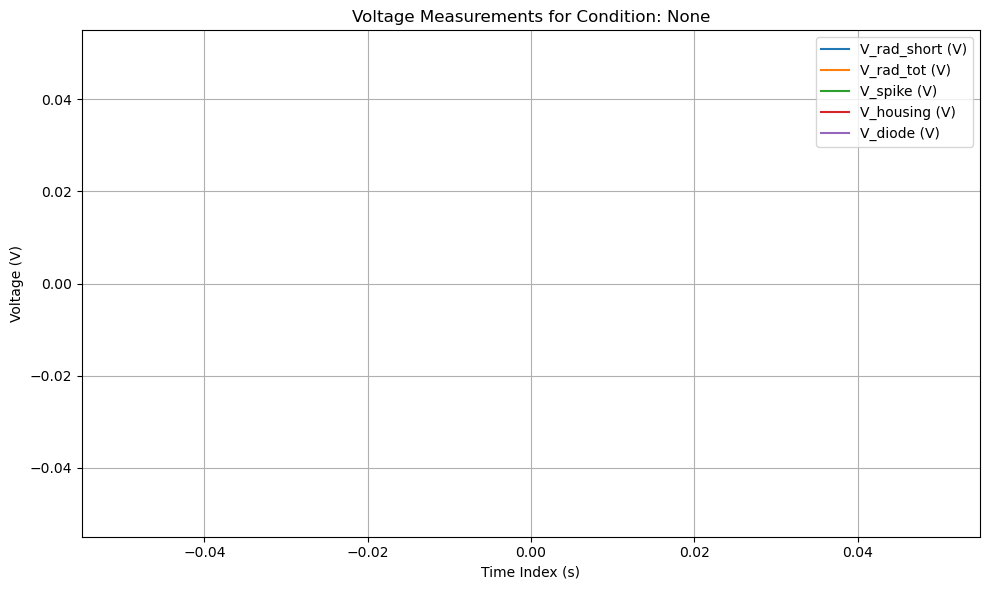

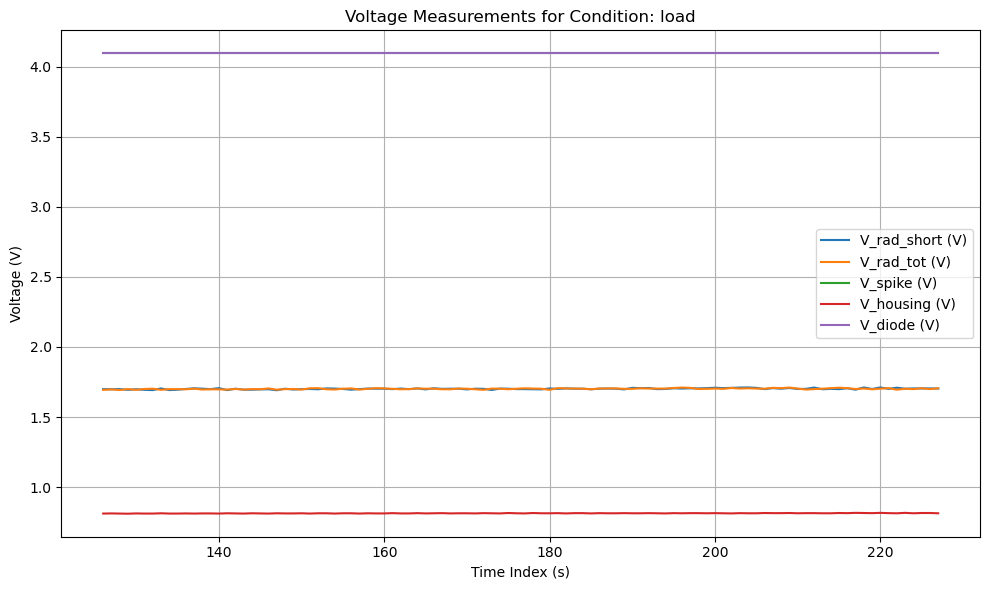

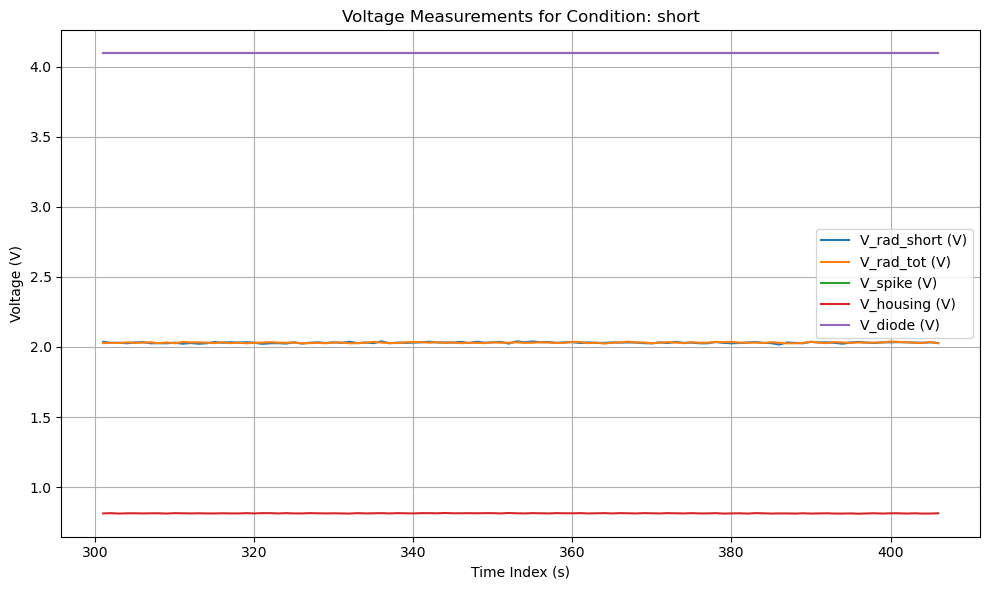

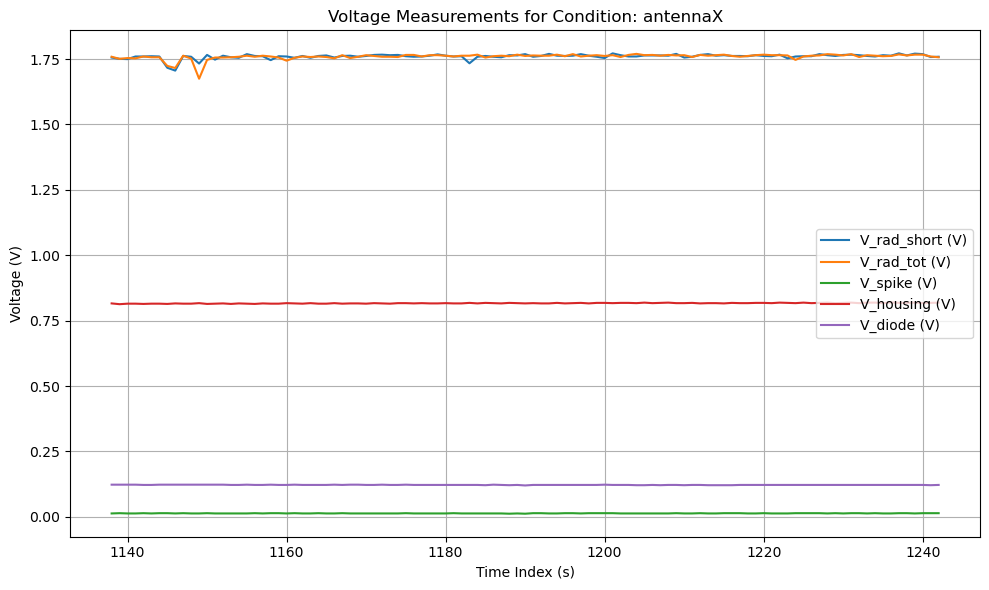

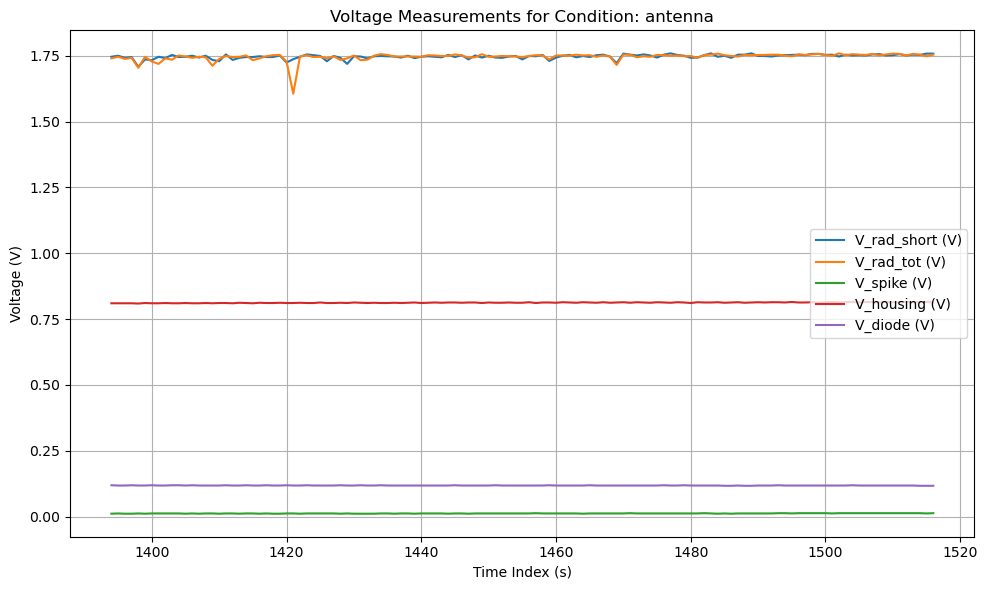

In [13]:
variables = ['V_rad_short', 'V_rad_tot', 'V_spike', 'V_housing', 'V_diode']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

for cond in all_X['class'].unique():
    subset = all_X[all_X['class'] == cond]
    plt.figure(figsize=(10, 6))
    for var in variables:
        plt.plot(subset.time_index, subset[var] / 1000, label=labels[var])
    # Find cooling start (0->1) and stop (1->0) indices
    flag = subset['cooling_flag_1'].values
    time_idx = subset['time_index'].values[:-1]
    starts = time_idx[(flag[:-1] == 0) & (flag[1:] == 1)]+1
    stops = time_idx[(flag[:-1] == 1) & (flag[1:] == 0)]+1
    for s in starts:
        plt.axvline(s, color='blue', linestyle='--', alpha=0.7, label='Cooling Start')
    for s in stops:
        plt.axvline(s, color='red', linestyle='-.', alpha=0.7, label='Cooling Stop')
    # Avoid duplicate legend entries
    handles, plot_labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(plot_labels, handles))
    plt.title(f"Voltage Measurements for Condition: {cond}")
    plt.xlabel("Time Index (s)")
    plt.ylabel("Voltage (V)")
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
# Create a new time index with 20-second gaps between classes
gap_duration = 20  # seconds between each class
class_order = ['short', 'load', 'antenna']  # Define the order

# Initialize time_index_2 column
all_X['time_index_2'] = 0.0
current_time = 0

for i, class_name in enumerate(class_order):
    # Get data for this class
    class_data = all_X[all_X['class'] == class_name].copy()
    
    if len(class_data) > 0:
        # Sort by original time_index to maintain chronological order
        class_data = class_data.sort_values('time_index')
        
        # Create new continuous time index for this class
        duration = len(class_data)
        new_time_indices = np.arange(current_time, current_time + duration)
        
        # Update the main dataframe
        mask = all_X['class'] == class_name
        all_X.loc[mask, 'time_index_2'] = new_time_indices
        
        # Update current_time for next class (add duration + gap)
        current_time += duration + gap_duration
        
        print(f"Class '{class_name}': {len(class_data)} data points, time range: {new_time_indices[0]:.1f} - {new_time_indices[-1]:.1f} s")

print(f"\nTotal duration: {current_time - gap_duration:.1f} seconds")

Class 'short': 106 data points, time range: 0.0 - 105.0 s
Class 'load': 102 data points, time range: 126.0 - 227.0 s
Class 'antenna': 123 data points, time range: 248.0 - 370.0 s

Total duration: 371.0 seconds


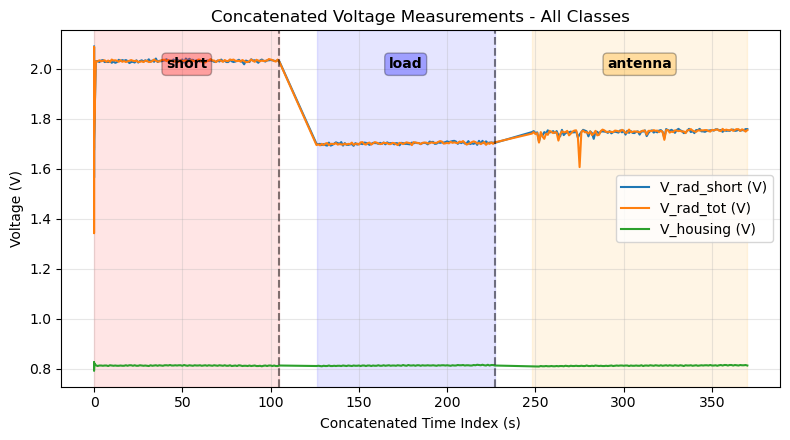


Data summary by class:
short: 106 points, time range: 0.0 - 105.0 s
load: 102 points, time range: 126.0 - 227.0 s
antenna: 123 points, time range: 248.0 - 370.0 s


In [30]:
# Plot all data using the new concatenated time index
plt.figure(figsize=(8, 4.5))

# Define colors for each class
class_colors = {
    'load': 'blue',
    'short': 'red', 
    'antennaX': 'green',
    'antenna': 'orange'
}

# Plot each voltage variable
variables = ['V_rad_short', 'V_rad_tot', 'V_housing']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

# Sort data by time_index_2 for proper plotting
data_sorted = all_X.sort_values('time_index_2')

for var in variables:
    plt.plot(data_sorted['time_index_2'], data_sorted[var] / 1000, label=labels[var])

# Add vertical lines to separate classes and color-code background
class_boundaries = []
current_pos = 0

for class_name in class_order:
    class_data = all_X[all_X['class'] == class_name]
    if len(class_data) > 0:
        class_start = class_data['time_index_2'].min()
        class_end = class_data['time_index_2'].max()
        
        # Add background color for each class
        plt.axvspan(class_start, class_end, alpha=0.1, color=class_colors[class_name], label=f'{class_name} region')
        
        # Add vertical line at the end of each class (except the last one)
        if class_name != class_order[-1]:
            plt.axvline(class_end, color='black', linestyle='--', alpha=0.5)
        
        # Add text annotation for class name
        class_center = (class_start + class_end) / 2
        plt.text(class_center, plt.ylim()[1] * 0.95, class_name, 
                ha='center', va='top', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=class_colors[class_name], alpha=0.3))

plt.title("Concatenated Voltage Measurements - All Classes")
plt.xlabel("Concatenated Time Index (s)")
plt.ylabel("Voltage (V)")
plt.grid(True, alpha=0.3)

# Create legend with voltage variables only (avoid duplicate region labels)
voltage_handles = [plt.Line2D([0], [0], color=plt.gca().get_lines()[i].get_color(), 
                             label=labels[var]) 
                  for i, var in enumerate(variables)]
plt.legend(handles=voltage_handles, loc='right')

plt.tight_layout()
plt.show()

# Print summary
print("\nData summary by class:")
for class_name in class_order:
    class_data = all_X[all_X['class'] == class_name]
    if len(class_data) > 0:
        time_range = f"{class_data['time_index_2'].min():.1f} - {class_data['time_index_2'].max():.1f} s"
        print(f"{class_name}: {len(class_data)} points, time range: {time_range}")